In [162]:
%%capture
import numpy as np
from matplotlib import pyplot as plt
import itertools
from sklearn.utils import shuffle
import tensorflow as tf
%run "./utils.ipynb"
%run "./Data preprocessing.ipynb"
# %run "./Data preprocessing-for-hyperparams.ipynb"

In [163]:
X.shape

(17615, 100, 100)

In [164]:
X = tf.keras.applications.inception_resnet_v2.preprocess_input(X)

In [165]:
X = np.stack((X,)*3, axis=-1)
print(X.shape)

(17615, 100, 100, 3)


In [107]:
new_X = tf.image.resize(
    X, [299,299], method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)
new_X.shape
X = np.array(new_X)

In [166]:
X.shape

(17615, 100, 100, 3)

In [167]:
from tensorflow.keras.applications import VGG16,VGG19,NASNetMobile,DenseNet201
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam 

In [168]:
from sklearn.model_selection import train_test_split
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state = 42, stratify=y) 

In [170]:
def scheduler(epoch, lr):
  if epoch < 8:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

cb_3 = tf.keras.callbacks.LearningRateScheduler(scheduler)
cb_1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0) 
cb_2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=3, verbose=1, mode='auto', restore_best_weights=True)

cbs = [cb_1 , cb_2, cb_3 ]

In [171]:
model = Sequential()


conv_base = tf.keras.applications.InceptionResNetV2(input_shape=(100,100,3), include_top=False, pooling='max',weights='imagenet')


model.add(conv_base)
model.add(BatchNormalization())   
model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax')) 


model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

In [172]:
model.summary() 

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
batch_normalization_5943 (Ba (None, 1536)              6144      
_________________________________________________________________
dense_56 (Dense)             (None, 2048)              3147776   
_________________________________________________________________
batch_normalization_5944 (Ba (None, 2048)              8192      
_________________________________________________________________
dense_57 (Dense)             (None, 5)                 10245     
Total params: 57,509,093
Trainable params: 57,441,381
Non-trainable params: 67,712
_________________________________________________________________


In [173]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=12, callbacks=cbs,verbose=1) 

Epoch 1/12
413/413 [==============================] - 1267s 3s/step - loss: 434.6607 - accuracy: 0.6031 - val_loss: 1468.2471 - val_accuracy: 0.7327
Epoch 2/12
413/413 [==============================] - 1307s 3s/step - loss: 18.8245 - accuracy: 0.7468 - val_loss: 3.6262 - val_accuracy: 0.5540
Epoch 3/12
413/413 [==============================] - 1259s 3s/step - loss: 2.7967 - accuracy: 0.8536 - val_loss: 4.5492 - val_accuracy: 0.8002
Epoch 4/12
413/413 [==============================] - 1260s 3s/step - loss: 2.4459 - accuracy: 0.9209 - val_loss: 2.6701 - val_accuracy: 0.8590
Epoch 5/12
413/413 [==============================] - 1200s 3s/step - loss: 1.0916 - accuracy: 0.9557 - val_loss: 4.3650 - val_accuracy: 0.7243
Epoch 6/12
413/413 [==============================] - 1256s 

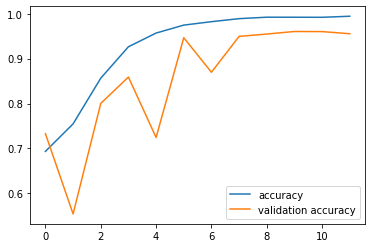

In [174]:
accuracy_graph(history)

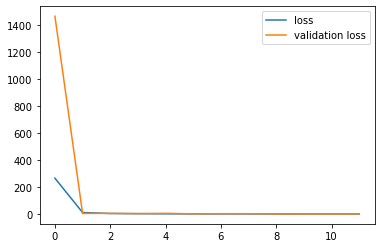

In [175]:
loss_graph(history)

In [196]:
model.save('./InceptionResNetV2.h5')

In [203]:
predictions = model.predict(X_test[700:1000]).argmax(axis=1)
cm = confusion_matrix(y_test[700:1000], predictions)

Confusion matrix, without normalization
[[56  0  1  1  1]
 [ 0 62  4  0  0]
 [ 0  0 69  0  0]
 [ 0  0  0 50  1]
 [ 2  0  0  0 53]]


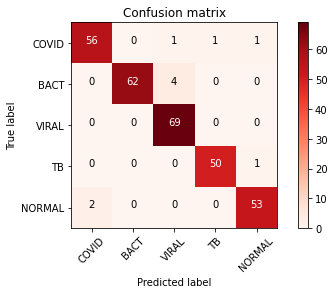

In [204]:
plot_confusion_matrix(cm, ["COVID" ,"BACT", "VIRAL", "TB", "NORMAL"])

In [205]:
print(classification_report(y_test[700:1000], predictions))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        59
           1       1.00      0.94      0.97        66
           2       0.93      1.00      0.97        69
           3       0.98      0.98      0.98        51
           4       0.96      0.96      0.96        55

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300

